In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import context

In [3]:
from IPython.display import display

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [5]:
import os
import pickle
import numpy as np
from datetime import datetime

In [6]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, ToPILImage, Lambda, Compose
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

In [7]:
from bestiary.criteria.autoencoder import AutoEncoderLoss

In [8]:
from bestiary.nets.wgan import GenerativeAdversarialNet, WassersteinGenerativeAdversarialNet

In [9]:
from bestiary.models import unsupervised

In [10]:
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, Checkpoint, ProgressBar, Callback
from skorch.callbacks import TensorBoard, BatchScoring, EpochScoring, PassthroughScoring, LRScheduler

In [11]:
import matplotlib.pyplot as plt

In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from tensorboardX import SummaryWriter

In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [14]:
from sklearn.datasets import fetch_openml

In [15]:
from skopt import BayesSearchCV

In [16]:
from scipy.stats import loguniform, randint

In [17]:
from bestiary.models.adversarial.gan import Generator, Discriminator

# Data

In [18]:
mnist = MNIST('data', download=True, transform=Compose([ToTensor(), Lambda(lambda x: x.reshape(-1))]))

In [25]:
mnist = Subset(mnist, np.arange(5000))

In [17]:
dataloader = DataLoader(mnist, batch_size=64, shuffle=True)

In [18]:
generator = Generator(latent_dim=4, n_layers=2, hidden_dim=256)
discriminator = Discriminator(hidden_dim=128, n_layers=2)

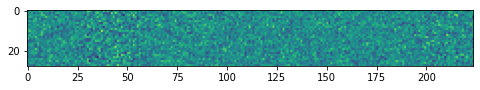

In [19]:
fake_grid = generator.generate(8)
fake_grid = np.concatenate([g.reshape(28, 28).detach() for g in fake_grid], axis=1)

plt.figure(figsize=(8, 8))
plt.imshow(fake_grid)
plt.show()

In [20]:
opt_gen = torch.optim.Adam(generator.parameters(), lr=1e-4)
opt_disc = torch.optim.Adam(discriminator.parameters(), lr=5e-5)

In [21]:
criterion = nn.BCELoss()

Epoch 0
tensor(0.0074) tensor(-0.3456)
Fake grid : [0.5118721  0.5118131  0.5118336  0.51186216 0.51182324 0.51190865
 0.5118738  0.51188016]
True grid : [0.51231426 0.5108585  0.5118712  0.51261896 0.5132495  0.51164174
 0.50737935 0.50938654]


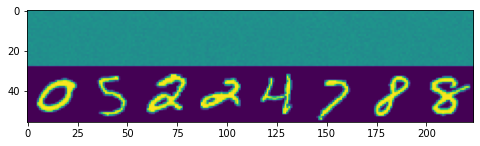

Epoch 1
tensor(0.0058) tensor(-0.3561)
Fake grid : [0.44425097 0.47636887 0.44958478 0.46566477 0.4344342  0.51145744
 0.5303979  0.50350195]
True grid : [0.5377397  0.5476636  0.45776603 0.49475607 0.5120497  0.5481546
 0.5744672  0.48718292]


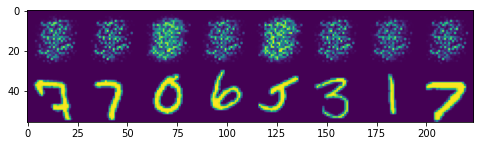

Epoch 2
tensor(0.0057) tensor(-0.3679)
Fake grid : [0.45564744 0.502439   0.5095487  0.47944054 0.5110001  0.5028447
 0.4807569  0.50548905]
True grid : [0.54953265 0.41817716 0.5659572  0.34607658 0.5040769  0.3163198
 0.602819   0.60918725]


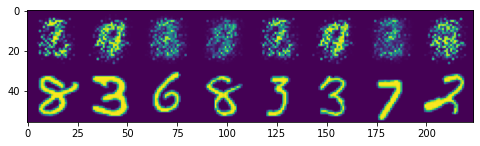

Epoch 3
tensor(0.0061) tensor(-0.3514)
Fake grid : [0.25783804 0.20808785 0.20462088 0.35379463 0.27569124 0.33610663
 0.295152   0.4518832 ]
True grid : [0.54305077 0.5596667  0.48240194 0.62854534 0.33720613 0.23164998
 0.26976895 0.8927681 ]


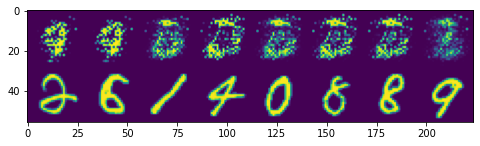

Epoch 4
tensor(0.0060) tensor(-0.3405)
Fake grid : [0.28169668 0.6792862  0.42943925 0.42848822 0.45512617 0.36461842
 0.26445574 0.47185543]
True grid : [0.42726812 0.9537098  0.22236058 0.5487158  0.4842663  0.7061552
 0.8089686  0.62091446]


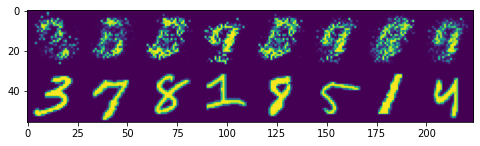

Epoch 5
tensor(0.0055) tensor(-0.3422)
Fake grid : [0.7017724  0.47736374 0.39050782 0.2106444  0.17191486 0.36338973
 0.62255174 0.3058799 ]
True grid : [0.41674998 0.7493163  0.6280397  0.7846278  0.97973025 0.6765555
 0.53551203 0.9628333 ]


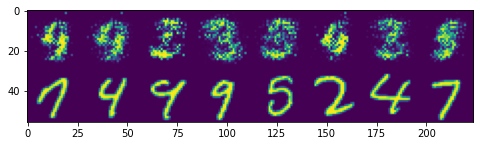

Epoch 6
tensor(0.0064) tensor(-0.3351)
Fake grid : [0.32355982 0.14488366 0.33103618 0.35436663 0.18603243 0.31038025
 0.21107945 0.23981375]
True grid : [0.26923856 0.9805295  0.61752164 0.7390023  0.4781946  0.7321741
 0.6458626  0.93560684]


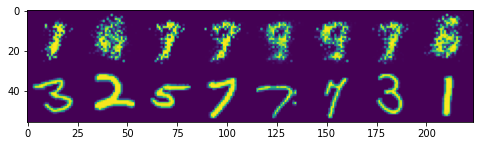

Epoch 7
tensor(0.0065) tensor(-0.3276)
Fake grid : [0.1653539  0.21057622 0.21747422 0.23782256 0.12996325 0.5099403
 0.22113422 0.26310948]
True grid : [0.7045103  0.9359028  0.89427644 0.92501616 0.2773467  0.7098912
 0.5573152  0.8591434 ]


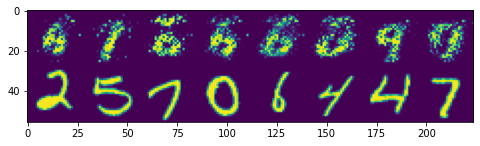

Epoch 8
tensor(0.0066) tensor(-0.3568)
Fake grid : [0.22627349 0.27037808 0.41582537 0.19745074 0.15916608 0.3287427
 0.20919357 0.16317677]
True grid : [0.16268949 0.5497921  0.8006906  0.9978574  0.99820554 0.7215475
 0.1641848  0.04436151]


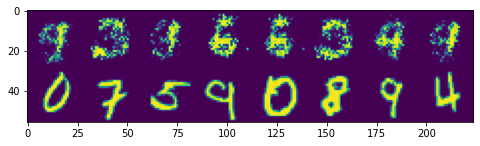

Epoch 9
tensor(0.0066) tensor(-0.3738)
Fake grid : [0.3619588  0.61297804 0.22912262 0.50869185 0.26949134 0.3527924
 0.38002115 0.20663697]
True grid : [0.6242338  0.47440287 0.9942932  0.9806151  0.97352594 0.61773455
 0.22850306 0.678986  ]


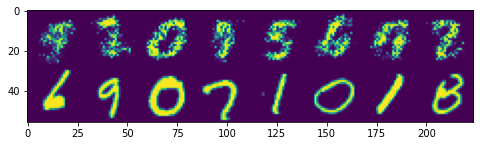

Epoch 10
tensor(0.0069) tensor(-0.3756)
Fake grid : [0.19507782 0.25795665 0.5114578  0.29155186 0.13661978 0.22181402
 0.6984163  0.10716229]
True grid : [0.99254966 0.58352715 0.99878925 0.821519   0.07723656 0.70775896
 0.78653735 0.99039525]


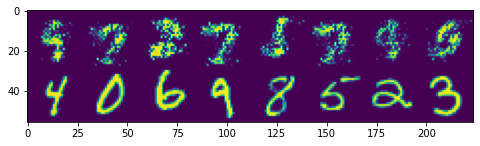

Epoch 11
tensor(0.0072) tensor(-0.3703)
Fake grid : [0.41778824 0.42279053 0.6172707  0.51985365 0.10875145 0.17287426
 0.15069722 0.245257  ]
True grid : [0.8701745  0.345143   0.997332   0.96559596 0.82757306 0.7682195
 0.7624898  0.46085894]


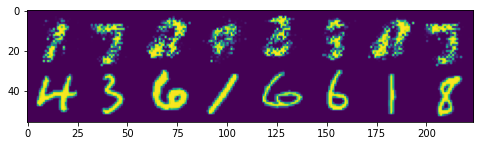

Epoch 12
tensor(0.0073) tensor(-0.3577)
Fake grid : [0.39160275 0.5154481  0.3650981  0.2654927  0.5234524  0.18802743
 0.47461814 0.352845  ]
True grid : [0.81862617 0.74194616 0.6578432  0.6914063  0.7632695  0.57469493
 0.11861337 0.95926934]


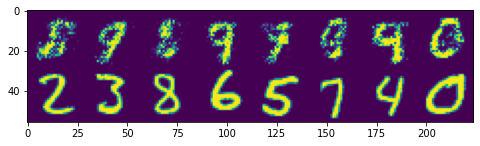

Epoch 13
tensor(0.0075) tensor(-0.3671)
Fake grid : [0.25785282 0.33742255 0.3418945  0.06481083 0.23805138 0.3642638
 0.36525828 0.3980097 ]
True grid : [0.2991382  0.82123053 0.10822653 0.21932785 0.94964755 0.8583995
 0.07905082 0.9558663 ]


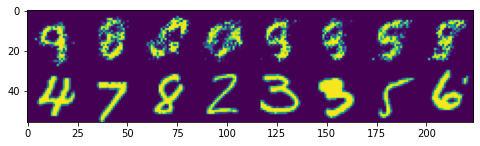

Epoch 14
tensor(0.0077) tensor(-0.3780)
Fake grid : [0.26310235 0.13273972 0.59990907 0.2353075  0.37422302 0.6432921
 0.27388683 0.53510946]
True grid : [0.026084   0.75835735 0.69800794 0.6441921  0.36443385 0.5574815
 0.16967274 0.976935  ]


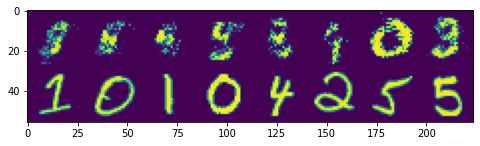

Epoch 15
tensor(0.0078) tensor(-0.3994)
Fake grid : [0.4755466  0.5676758  0.19630538 0.7036475  0.34174523 0.3854164
 0.36156565 0.5738704 ]
True grid : [0.9814214  0.6514189  0.3564012  0.62533104 0.9596511  0.5330613
 0.48758572 0.9835982 ]


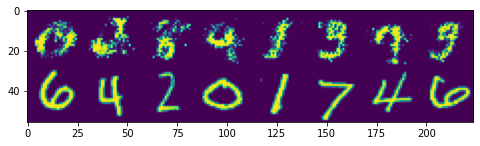

Epoch 16
tensor(0.0078) tensor(-0.4043)
Fake grid : [0.1667744  0.38474816 0.29019785 0.09255774 0.17723173 0.25503933
 0.24706797 0.27474657]
True grid : [0.993765   0.2175514  0.8925263  0.6331362  0.6137937  0.76851803
 0.44549313 0.9327505 ]


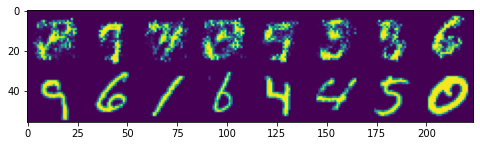

Epoch 17
tensor(0.0079) tensor(-0.4080)
Fake grid : [0.2094899  0.2416785  0.28083584 0.37340128 0.30049273 0.7245825
 0.573007   0.54153705]
True grid : [0.8065507 0.9741158 0.9112953 0.9036114 0.7763896 0.5961826 0.6144376
 0.377063 ]


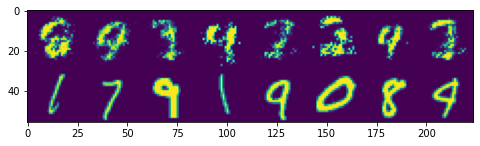

Epoch 18
tensor(0.0079) tensor(-0.4308)
Fake grid : [0.44126064 0.27897993 0.4077247  0.38834637 0.38750872 0.3153278
 0.22505808 0.42471245]
True grid : [0.61504585 0.45280957 0.9293252  0.49038085 0.6044626  0.84992933
 0.68007857 0.8288437 ]


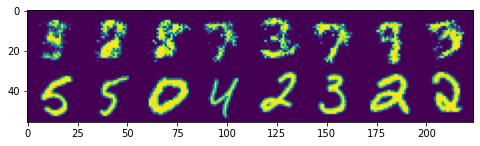

Epoch 19
tensor(0.0080) tensor(-0.4245)
Fake grid : [0.41409987 0.34946954 0.25027487 0.34714398 0.35082808 0.1549788
 0.84380084 0.5667003 ]
True grid : [0.7973513  0.9555749  0.7897621  0.25511628 0.4254123  0.77169704
 0.50718236 0.7349705 ]


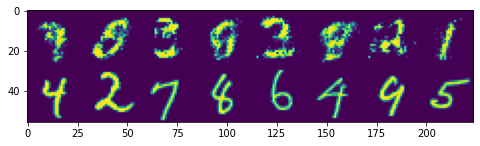

Epoch 20
tensor(0.0079) tensor(-0.4401)
Fake grid : [0.22544909 0.384527   0.3991605  0.35235706 0.49305704 0.43300647
 0.47992873 0.2601883 ]
True grid : [0.9824576  0.34697708 0.26369262 0.69622    0.50291526 0.7681229
 0.3235991  0.33552742]


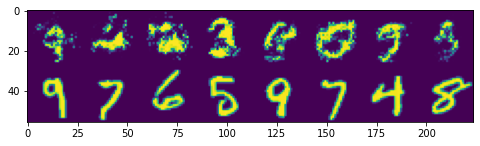

Epoch 21
tensor(0.0082) tensor(-0.4530)
Fake grid : [0.47863036 0.5527469  0.51115084 0.38039213 0.4211589  0.51132166
 0.5223342  0.2545041 ]
True grid : [0.8906463  0.7550701  0.9344427  0.6176249  0.50884426 0.45611078
 0.772843   0.77297676]


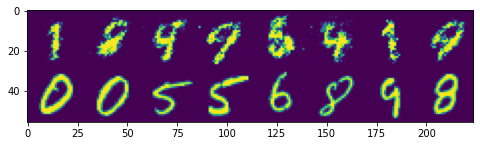

Epoch 22
tensor(0.0082) tensor(-0.4581)
Fake grid : [0.19539145 0.25246108 0.26515853 0.48647538 0.18182455 0.6669318
 0.41757038 0.39524654]
True grid : [0.11263479 0.7284635  0.55812246 0.57396156 0.28059274 0.7523384
 0.9886176  0.60420144]


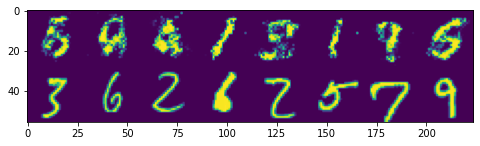

Epoch 23
tensor(0.0082) tensor(-0.4502)
Fake grid : [0.6814765  0.3958908  0.45126435 0.23861726 0.33203736 0.18791758
 0.25750166 0.3162429 ]
True grid : [0.5545627  0.5265864  0.9783412  0.51662177 0.5783476  0.3886511
 0.6471226  0.86777157]


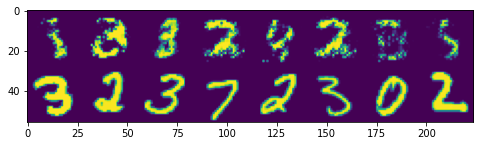

Epoch 24
tensor(0.0082) tensor(-0.4680)
Fake grid : [0.27197695 0.5429279  0.43541873 0.32042164 0.43502185 0.3977614
 0.5535248  0.5967822 ]
True grid : [0.9579666  0.41567323 0.50694495 0.7292112  0.349243   0.22757195
 0.85864633 0.5469522 ]


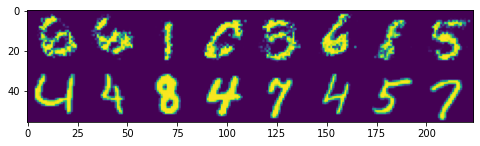

Epoch 25
tensor(0.0082) tensor(-0.4567)
Fake grid : [0.3940402  0.61333567 0.3636368  0.5955057  0.5268304  0.48515996
 0.6832621  0.48690954]
True grid : [0.27582848 0.41502377 0.48673162 0.53429276 0.33505604 0.54541916
 0.80552274 0.82033414]


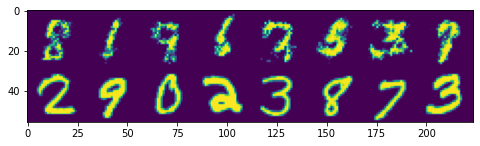

Epoch 26
tensor(0.0082) tensor(-0.4516)
Fake grid : [0.2855031  0.59555423 0.53883076 0.21971165 0.4642933  0.45030975
 0.36498868 0.40190125]
True grid : [0.596269   0.34556738 0.54656273 0.5861706  0.38321835 0.951159
 0.37959522 0.30036232]


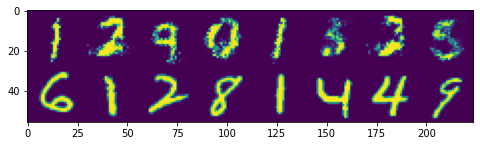

Epoch 27
tensor(0.0082) tensor(-0.4511)
Fake grid : [0.2233758  0.32885683 0.44786456 0.53540826 0.4462933  0.5429625
 0.36217245 0.44169524]
True grid : [0.16915542 0.67086154 0.5451178  0.64236665 0.9163102  0.63172424
 0.6091446  0.13065992]


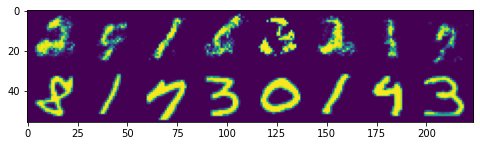

Epoch 28
tensor(0.0082) tensor(-0.4559)
Fake grid : [0.41979414 0.28948995 0.581402   0.33299872 0.32420513 0.26799726
 0.39241406 0.56720203]
True grid : [0.23564675 0.8675039  0.88993037 0.585855   0.47326314 0.8957165
 0.86708075 0.68968064]


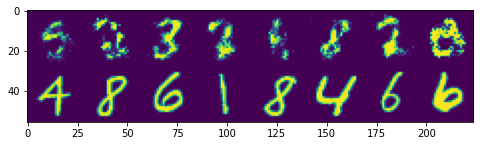

Epoch 29
tensor(0.0082) tensor(-0.4542)
Fake grid : [0.25636834 0.19192034 0.18956997 0.3755053  0.29792854 0.37077624
 0.35891122 0.20521681]
True grid : [0.31364194 0.21508092 0.61425257 0.9120844  0.23086904 0.59458387
 0.9829685  0.9746018 ]


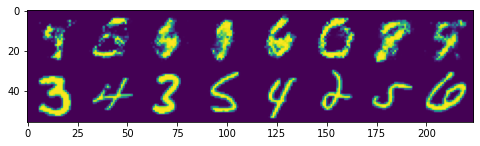

Epoch 30
tensor(0.0082) tensor(-0.4686)
Fake grid : [0.45951268 0.482943   0.40979126 0.35322824 0.3153237  0.41212592
 0.359419   0.595273  ]
True grid : [0.7481652  0.77024096 0.57238305 0.49737602 0.91063637 0.4859719
 0.36286947 0.7601736 ]


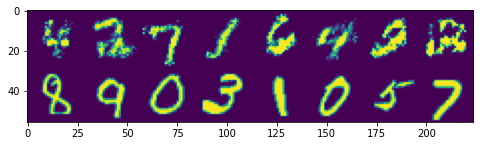

Epoch 31
tensor(0.0082) tensor(-0.4546)
Fake grid : [0.3369811  0.43402717 0.3539416  0.4332337  0.40453365 0.4366515
 0.54199094 0.40656877]
True grid : [0.6223556  0.3676928  0.33710194 0.5135428  0.4434011  0.8725331
 0.46424735 0.87492704]


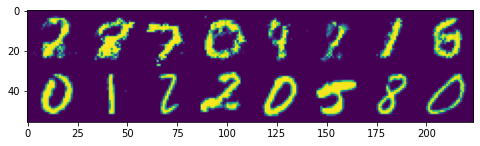

Epoch 32
tensor(0.0082) tensor(-0.4657)
Fake grid : [0.61013454 0.3061791  0.47810563 0.29562503 0.5756433  0.45696774
 0.46953493 0.57194275]
True grid : [0.4143719  0.8889762  0.53831875 0.20882572 0.6987055  0.9029545
 0.9949656  0.24743445]


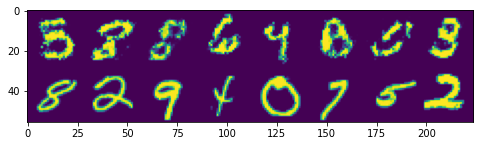

Epoch 33
tensor(0.0081) tensor(-0.4707)
Fake grid : [0.41289625 0.36638182 0.3537568  0.4146535  0.4887859  0.29964924
 0.36516675 0.3845753 ]
True grid : [0.5207529  0.434454   0.7152018  0.37491825 0.95249337 0.8742195
 0.9400932  0.6002455 ]


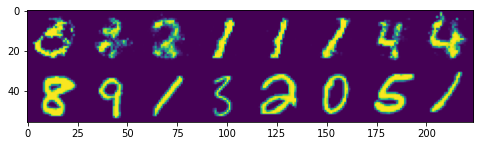

Epoch 34
tensor(0.0081) tensor(-0.4650)
Fake grid : [0.33063063 0.39444003 0.430874   0.3200155  0.41111848 0.343251
 0.4943301  0.77543354]
True grid : [0.6732285  0.48699367 0.69970244 0.5866875  0.38803527 0.49361095
 0.6084386  0.67170566]


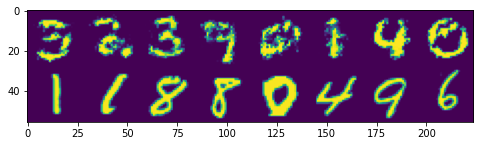

Epoch 35
tensor(0.0080) tensor(-0.4598)
Fake grid : [0.4147626  0.28907353 0.31202832 0.46363047 0.29551917 0.4226167
 0.5924804  0.5058776 ]
True grid : [0.8526726  0.43200472 0.31527132 0.23807871 0.29447114 0.48949447
 0.5724116  0.5822106 ]


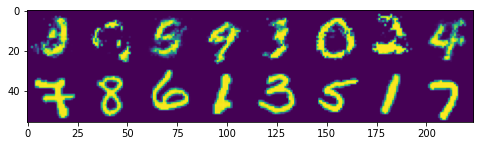

Epoch 36
tensor(0.0080) tensor(-0.4626)
Fake grid : [0.49925688 0.33309764 0.3018812  0.32251966 0.4011782  0.2359944
 0.37412113 0.55423945]
True grid : [0.7426546  0.534958   0.3073538  0.5584988  0.72982544 0.5295192
 0.92311466 0.49249488]


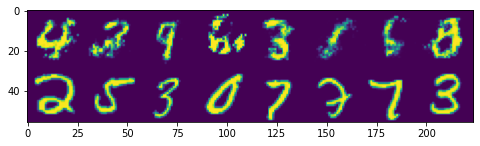

Epoch 37
tensor(0.0080) tensor(-0.4669)
Fake grid : [0.39177975 0.3454056  0.5366876  0.3793142  0.48017824 0.28549793
 0.35036892 0.57185733]
True grid : [0.33242223 0.4747524  0.52734995 0.7514293  0.4159686  0.89411515
 0.5334077  0.7147992 ]


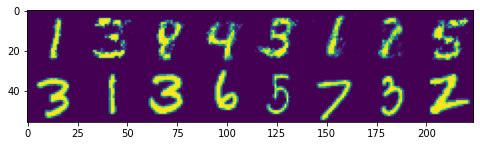

Epoch 38
tensor(0.0080) tensor(-0.4642)
Fake grid : [0.51525307 0.3685856  0.44037634 0.3466305  0.53377485 0.6591473
 0.7195809  0.52091384]
True grid : [0.46920025 0.85678613 0.5136987  0.83956677 0.33134407 0.7682302
 0.71446097 0.61122763]


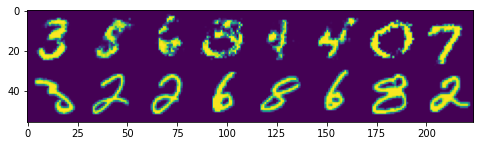

Epoch 39
tensor(0.0079) tensor(-0.4649)
Fake grid : [0.3095566  0.42949122 0.48206568 0.4232504  0.40743575 0.5287832
 0.31926018 0.3587727 ]
True grid : [0.6785845  0.4224813  0.41794077 0.7936044  0.7518724  0.6638913
 0.64229345 0.7428693 ]


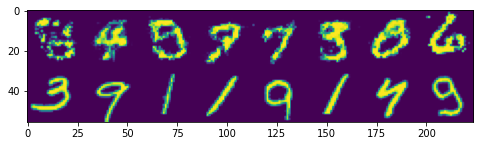

Epoch 40
tensor(0.0079) tensor(-0.4626)
Fake grid : [0.40854526 0.43108323 0.3903836  0.60680026 0.31249124 0.3474293
 0.35049444 0.4903921 ]
True grid : [0.33629584 0.46873924 0.32279125 0.5842109  0.6306703  0.96360177
 0.4549812  0.35057506]


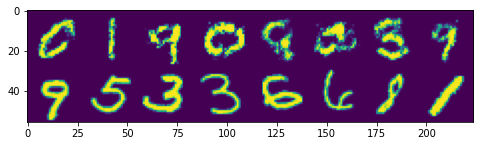

Epoch 41
tensor(0.0079) tensor(-0.4583)
Fake grid : [0.377592   0.62886953 0.5164161  0.5391492  0.4996568  0.9129813
 0.69206107 0.5915076 ]
True grid : [0.6012748  0.7479163  0.4107587  0.7176077  0.73823494 0.53705496
 0.76963913 0.4598104 ]


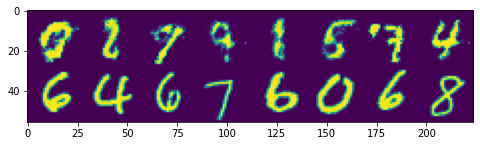

Epoch 42
tensor(0.0079) tensor(-0.4587)
Fake grid : [0.39937735 0.48841843 0.50992763 0.38930744 0.37468117 0.6358776
 0.26367277 0.50632143]
True grid : [0.91241854 0.53190327 0.328144   0.62534326 0.6661184  0.47310448
 0.4613884  0.5115919 ]


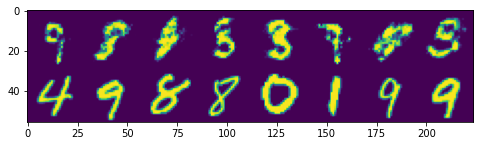

Epoch 43
tensor(0.0079) tensor(-0.4538)
Fake grid : [0.533916   0.5542277  0.3466226  0.6352588  0.47567922 0.24684766
 0.3714936  0.30070734]
True grid : [0.3867996  0.33666384 0.59106046 0.5247928  0.5987558  0.40961215
 0.37051442 0.810537  ]


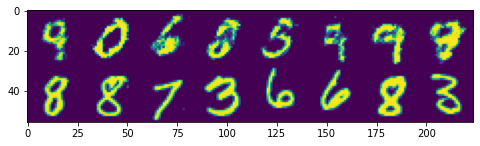

Epoch 44
tensor(0.0079) tensor(-0.4513)
Fake grid : [0.29915053 0.3283159  0.37206003 0.9126957  0.35061777 0.58021766
 0.83901703 0.26050925]
True grid : [0.30169034 0.782801   0.23037973 0.37074462 0.6805405  0.82542545
 0.6939623  0.42539936]


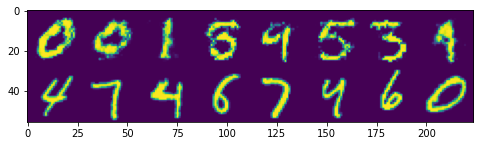

Epoch 45
tensor(0.0079) tensor(-0.4554)
Fake grid : [0.45897526 0.34651726 0.31748447 0.65678203 0.4416007  0.35485247
 0.8329025  0.50754577]
True grid : [0.5066944  0.5351072  0.40791878 0.83460313 0.6052661  0.41117305
 0.2936004  0.46570086]


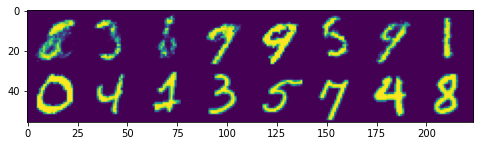

Epoch 46
tensor(0.0078) tensor(-0.4528)
Fake grid : [0.41779464 0.44648278 0.34599742 0.59792304 0.44395867 0.4529932
 0.43456194 0.49322796]
True grid : [0.80879474 0.51673913 0.55115753 0.35466197 0.64806086 0.40374315
 0.4029925  0.7960059 ]


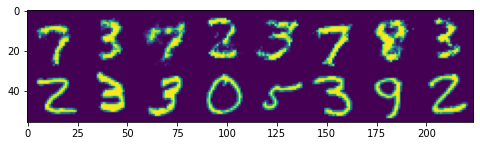

Epoch 47
tensor(0.0078) tensor(-0.4464)
Fake grid : [0.56294787 0.51739115 0.5332388  0.40697667 0.5245389  0.4859924
 0.39555198 0.40069172]
True grid : [0.89179033 0.88997644 0.59222984 0.40966132 0.38402548 0.5343169
 0.9994778  0.3959802 ]


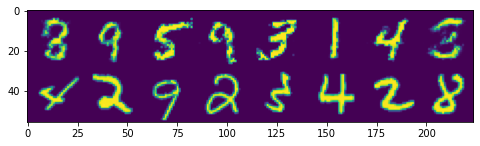

Epoch 48
tensor(0.0078) tensor(-0.4527)
Fake grid : [0.411614   0.5592437  0.31771308 0.41683114 0.47949886 0.41342515
 0.3837795  0.5752211 ]
True grid : [0.6635108  0.67958486 0.49454555 0.93170065 0.57131666 0.8284044
 0.39641508 0.9980806 ]


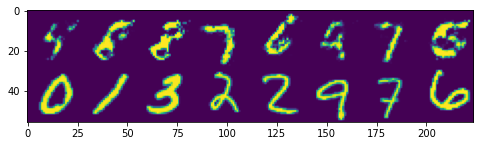

Epoch 49
tensor(0.0078) tensor(-0.4546)
Fake grid : [0.50730544 0.50526106 0.36891505 0.5591647  0.41364598 0.3940794
 0.5129412  0.4194909 ]
True grid : [0.31899983 0.5828782  0.44231942 0.35671645 0.5149334  0.45660737
 0.601556   0.5924181 ]


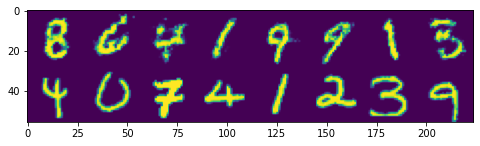

Epoch 50
tensor(0.0078) tensor(-0.4535)
Fake grid : [0.57936764 0.69271874 0.48930925 0.41286993 0.66855526 0.316294
 0.47045237 0.55714744]
True grid : [0.3866792  0.5741321  0.5722264  0.6249355  0.42076194 0.5344965
 0.6344401  0.38671723]


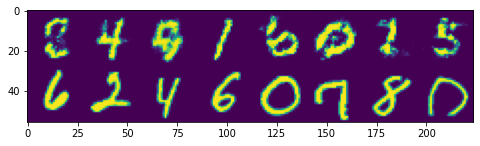

Epoch 51
tensor(0.0078) tensor(-0.4496)
Fake grid : [0.4758475  0.42461228 0.43254578 0.46743447 0.40274027 0.50795853
 0.34445116 0.553897  ]
True grid : [0.9835317  0.52014244 0.84775287 0.71091175 0.34540144 0.43122196
 0.5637691  0.6976011 ]


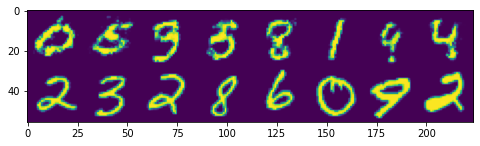

Epoch 52
tensor(0.0078) tensor(-0.4476)
Fake grid : [0.5223141  0.57185113 0.37815636 0.78140134 0.3151421  0.7549432
 0.31686148 0.45531753]
True grid : [0.6255891  0.4135238  0.5479764  0.32225484 0.57621163 0.43865415
 0.74957705 0.9888559 ]


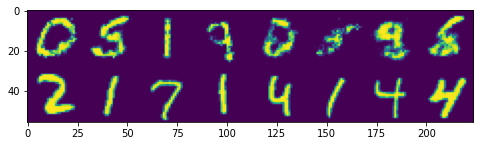

Epoch 53
tensor(0.0078) tensor(-0.4453)
Fake grid : [0.48721758 0.79764336 0.34918234 0.6074683  0.38919756 0.72497505
 0.6452064  0.5754295 ]
True grid : [0.85103834 0.85901904 0.7483492  0.5306867  0.51070684 0.37418264
 0.96376294 0.38311252]


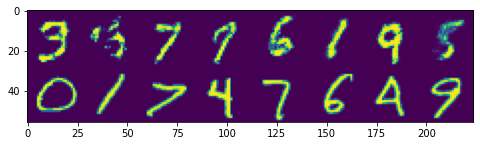

Epoch 54
tensor(0.0077) tensor(-0.4499)
Fake grid : [0.47109476 0.4484106  0.28372762 0.39464274 0.27480626 0.4119578
 0.41047168 0.25376576]
True grid : [0.5700044  0.42392012 0.83010757 0.5253869  0.29984534 0.76594937
 0.76258034 0.44542107]


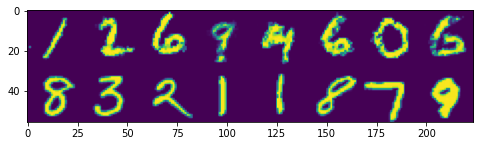

Epoch 55
tensor(0.0077) tensor(-0.4534)
Fake grid : [0.6053109  0.61640316 0.52599394 0.74195707 0.3028374  0.5063474
 0.31572402 0.3181636 ]
True grid : [0.7798792  0.78509426 0.7476209  0.31524396 0.93478113 0.69405556
 0.6592556  0.26413375]


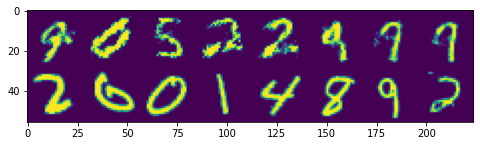

Epoch 56
tensor(0.0077) tensor(-0.4573)
Fake grid : [0.7478759  0.48853984 0.37463012 0.31012517 0.33267447 0.3100382
 0.38408569 0.6061189 ]
True grid : [0.42781138 0.86292815 0.48209804 0.31150314 0.35954687 0.6945681
 0.3879598  0.9998561 ]


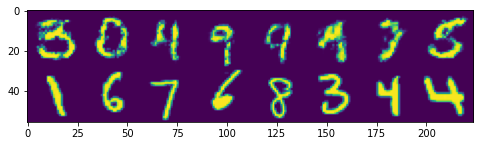

Epoch 57
tensor(0.0077) tensor(-0.4639)
Fake grid : [0.49469772 0.45027214 0.37057003 0.5571674  0.33253616 0.42149827
 0.6055472  0.44104457]
True grid : [0.6585087  0.7861675  0.24345279 0.9837467  0.47682378 0.69579893
 0.6885198  0.5911269 ]


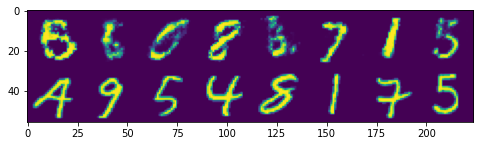

In [ ]:
for epoch in range(100):
    
    print(f'Epoch {epoch}')

    for i, (real, _) in enumerate(dataloader):
        
        generator.train()
        discriminator.train()
        
        b = real.shape[0]
        
        fake = generator.generate(b)
        
        y_pred_fake = discriminator(fake.detach())
        y_pred_real = discriminator(real)
        
        loss_fake = criterion(y_pred_fake, torch.zeros_like(y_pred_fake))
        loss_real = criterion(y_pred_real, torch.ones_like(y_pred_real))
        discriminator_loss = (loss_fake + loss_real) / 2
        
        opt_disc.zero_grad()
        discriminator_loss.backward()        
        opt_disc.step()

        generator_loss = criterion(discriminator(fake), torch.ones(b, 1))

        opt_gen.zero_grad()
        generator_loss.backward()
        opt_gen.step()
        
        if i % (len(dataloader) // 1 + 1) == 0:
            
            print(discriminator.state_dict()['net.0.weight'][0][0], generator.state_dict()['net.0.weight'][0][0])
            
            with torch.no_grad():
                generator.eval()
                discriminator.eval()
            
                fake_grid = generator.generate(8)
                print(f'Fake grid : {discriminator(fake_grid).numpy().reshape(-1)}')

                fake_grid = np.concatenate([g.reshape(28, 28) for g in fake_grid], axis=1)

                true_grid = real[:8]
                print(f'True grid : {discriminator(true_grid).numpy().reshape(-1)}')
                
                true_grid = np.concatenate([g.reshape(28, 28) for g in true_grid], axis=1)

                grid = np.concatenate((fake_grid, true_grid), axis=0)

                plt.figure(figsize=(8, 8))
                plt.imshow(grid)
                plt.show()

                #print(discriminator_loss, generator_loss)